# Debugging Nanosurf FlexAFM pause mode

While performing experiments with the FlexAFM, we consistently found that the pause mode does not perform as expected

Here, we illustrate the problem

In [49]:
%run _common.ipynb
from pathlib import Path
import re
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt

from jhelabtoolkit.io.nanosurf import nanosurf

In [4]:
data_dir = Path("../data/231120_nanosurf_pause_mode")
filepaths = {
    "no_ctrl": data_dir / "Image00033_pause_no_zctrl.nid",
    "ctrl": data_dir / "Image00034_pause_zctrl.nid",
    "ctrl_slow": data_dir / "Image00046_pause_zctrl_slow.nid",
}

In [85]:
config, data = nanosurf.read_nid(filepaths["no_ctrl"])

@dataclass
class Trajectory:
    time: np.ndarray
    pos: np.ndarray
    data: np.ndarray


def get_path_fwd(config, data):
    defl = data["spec forward"]["deflection"].to_numpy()
    z = data["spec forward"]["z-axis sensor"].to_numpy()

    total_time_str = config["DataSet\\Parameters\\Spectroscopy"]["FwModTime"]
    num_points_str = config["DataSet\\Parameters\\Spectroscopy"]["FwModDatapoints"]
    fmt_regex = re.compile(r"^[DLB]\[(\d+)\]\*\[\w*\]")
    total_time = float(fmt_regex.match(total_time_str).group(1))
    num_points = float(fmt_regex.match(num_points_str).group(1))
    t = np.arange(len(z)) * total_time / num_points
    return Trajectory(t, z, defl)


def get_path_bwd(config, data):
    defl = data["spec backward"]["deflection"].to_numpy()
    z = data["spec backward"]["z-axis sensor"].to_numpy()

    total_time_str = config["DataSet\\Parameters\\Spectroscopy"]["BwModTime"]
    num_points_str = config["DataSet\\Parameters\\Spectroscopy"]["BwModDatapoints"]
    fmt_regex = re.compile(r"^[DLB]\[(\d+)\]\*\[\w*\]")
    total_time = float(fmt_regex.match(total_time_str).group(1))
    num_points = float(fmt_regex.match(num_points_str).group(1))
    t = np.arange(len(z)) * total_time / num_points
    return Trajectory(t, z[::-1], defl[::-1])


def get_path_pause(config, data):
    defl = data["spec fwd pause"]["deflection"].to_numpy()
    z = data["spec fwd pause"]["z-axis sensor"].to_numpy()

    total_time_str = config["DataSet\\Parameters\\Spectroscopy"]["FwPauseTime"]
    num_points_str = config["DataSet\\Parameters\\Spectroscopy"]["FwPauseDatapoints"]
    fmt_regex = re.compile(r"^[DLB]\[(\d+)\]\*\[\w*\]")
    total_time = float(fmt_regex.match(total_time_str).group(1))
    num_points = float(fmt_regex.match(num_points_str).group(1))
    t = np.arange(len(z)) * total_time / num_points
    return Trajectory(t, z, defl)

fwd, pause, bwd = get_path_fwd(config, data), get_path_pause(config, data), get_path_bwd(config, data)


Text(0.5, 0.98, 'Pause mode with Z open loop')

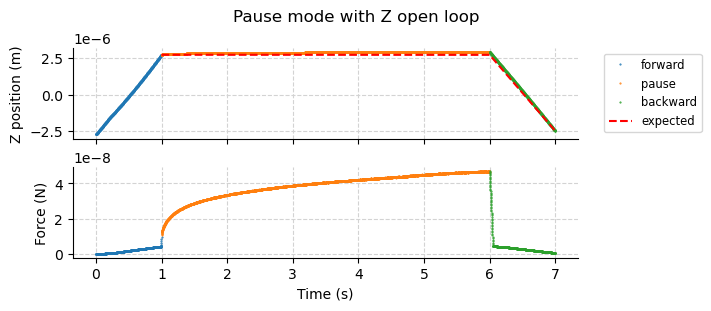

In [86]:
plot_kwargs = {"markersize": 1.0}
fig, axes = plt.subplots(2, 1, figsize = (7, 3), sharex = True, constrained_layout = True)

t_offset = 0
for traj, l in zip((fwd, pause, bwd), ("forward", "pause", "backward")):
    t_ = traj.time+t_offset
    axes[0].plot(t_, traj.pos, ".", label = l, **plot_kwargs)
    axes[1].plot(t_, traj.data, ".", label = l, **plot_kwargs)
    

    t_offset += traj.time[-1]
expected_z_pause = np.ones_like(pause.pos)*fwd.pos[-1]
expected_z_bwd = np.linspace(expected_z_pause[-1], bwd.pos[-1], len(bwd.pos))
expected_z = np.r_[expected_z_pause, expected_z_bwd]
axes[0].plot(np.r_[pause.time, bwd.time+pause.time[-1]]+fwd.time[-1], expected_z, "--", label = "expected", color = "red", **plot_kwargs)
axes[0].legend(fontsize = "small", bbox_to_anchor = (1.04,1.0))
axes[0].set_ylabel("Z position (m)")
axes[1].set_ylabel("Force (N)")
axes[1].set_xlabel("Time (s)")
fig.suptitle("Pause mode with Z open loop")

Text(0.5, 0.98, 'Close up of the forward pause for open loop')

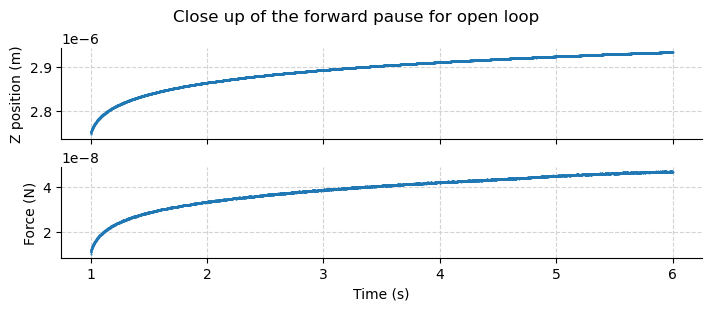

In [78]:
fig, axes = plt.subplots(2, 1, figsize = (7, 3), sharex = True, constrained_layout = True)
t_offset = fwd.time[-1]
axes[0].plot(pause.time+t_offset, pause.pos, ".", **plot_kwargs)
axes[1].plot(pause.time+t_offset, pause.data, ".", **plot_kwargs)
axes[0].set_ylabel("Z position (m)")
axes[1].set_ylabel("Force (N)")
axes[1].set_xlabel("Time (s)")
fig.suptitle("Close up of the forward pause for open loop")